<a href="https://colab.research.google.com/github/jolex007/COS_DL/blob/master/4_Homework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашняя работа №4

In [1]:
# Импортим все, что нужно

import torch
import torch.nn as nn
import torchvision

import torch.nn.functional as F

In [2]:
!pip install path

In [3]:
import numpy as np
import os
import path
from PIL import Image

In [4]:
torch.cuda.is_available()

True

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [6]:
dir_to_drive = path.Path('./gdrive/My Drive')
curr_dir = path.Path('COS/originals')

In [7]:
class BoxesDataset(torch.utils.data.Dataset):
    def __init__(self, path_to_dataset):
        '''
        :input:
            path_to_dataset - путь до файла с коробками
        '''
        self.transform = torchvision.transforms.Compose([
                                    torchvision.transforms.Resize((256, 256)),
                                    torchvision.transforms.Grayscale(num_output_channels=1),
                                    torchvision.transforms.ToTensor() # ,
                                    # torchvision.transforms.Normalize(mean=[0.5], std=[0.5])
        ])

        self.dir = path_to_dataset

        self.files_img = sorted(os.listdir(self.dir + '/img'))
        self.files_mask = sorted(os.listdir(self.dir + '/mask'))

        pass

    def __getitem__(self, indx):
        '''
        :input:
            indx - индекс
        '''
        picture_name = self.files_img[indx]
        img = Image.open(os.path.join(self.dir + '/img', picture_name))
        mask = Image.open(os.path.join(self.dir + '/mask', picture_name))

        return self.transform(img), self.transform(mask)
    
    def __len__(self):
        return len(self.files_img)
    
    pass


In [8]:
dataset = BoxesDataset(str(dir_to_drive/curr_dir))

In [9]:
train_dataset, test_dataset = torch.utils.data.random_split(dataset, (285, 30))

In [10]:
from collections import OrderedDict

class my_model(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, init_features=32):
        super(my_model, self).__init__()

        features = init_features
        
        # 1 encoder block
        self.encoder1 = my_model.__block_(in_channels, features, name='block1')
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # 2 encoder block
        self.encoder2 = my_model.__block_(features, features * 2, name='block2')
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # 3 encoder block
        self.encoder3 = my_model.__block_(features * 2, features * 4, name='block3')
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # 4 encoder block
        self.encoder4 = my_model.__block_(features * 4, features * 8, name='block4')
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Neck part
        self.neck = my_model.__block_(features * 8, features * 16, name='neck')

        # 4 decoder block
        self.upconv4 = nn.ConvTranspose2d(features * 16, features * 8, kernel_size=2, stride=2)
        self.decoder4 = my_model.__block_(features * 16, features * 8, name='dec4')

        # 3 decoder block
        self.upconv3 = nn.ConvTranspose2d(features * 8, features * 4, kernel_size=2, stride=2)
        self.decoder3 = my_model.__block_(features * 8, features * 4, name='dec3')

        # 2 decoder block
        self.upconv2 = nn.ConvTranspose2d(features * 4, features * 2, kernel_size=2, stride=2)
        self.decoder2 = my_model.__block_(features * 4, features * 2, name='dec2')

        # 1 decoder block
        self.upconv1 = nn.ConvTranspose2d(features * 2, features, kernel_size=2, stride=2)
        self.decoder1 = my_model.__block_(features * 2, features, name='dec1')

        # Last conv block
        self.conv = nn.Conv2d(in_channels=features, out_channels=out_channels, kernel_size=1)

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))
        
        neck = self.neck(self.pool4(enc4))

        dec4 = self.upconv4(neck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)

        return torch.sigmoid(self.conv(dec1))

        
    @staticmethod
    def __block_(in_channels, features, name):
        return nn.Sequential(
            OrderedDict(
                [
                    (
                        name + 'conv1',
                        nn.Conv2d(
                            in_channels=in_channels,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + 'norm1', nn.BatchNorm2d(num_features=features)),
                    (name + 'relu1', nn.ReLU(inplace=True)),
                    (
                        name + 'conv2',
                        nn.Conv2d(
                            in_channels=features,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False
                        ),
                    ),
                    (name + 'norm2', nn.BatchNorm2d(num_features=features)),
                    (name + 'relu2', nn.ReLU(inplace=True))
                ]
            )
        )


In [11]:
model = my_model()
model.cuda()

my_model(
  (encoder1): Sequential(
    (block1conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (block1norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (block1relu1): ReLU(inplace=True)
    (block1conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (block1norm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (block1relu2): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder2): Sequential(
    (block2conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (block2norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (block2relu1): ReLU(inplace=True)
    (block2conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (block2norm2): BatchNorm2d(64, eps=1e-05, mome

In [12]:
test = torch.randn((1, 1, 256, 256))
test = test.cuda()

In [13]:
# model(test)

In [14]:
!nvidia-smi

Wed Jul 22 10:40:18 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    77W / 149W |    358MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [15]:
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=8)
val_loader = torch.utils.data.DataLoader(test_dataset,
                                         batch_size=8)

In [16]:
class IoULoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(IoULoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        # inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #intersection is equivalent to True Positive count
        #union is the mutually inclusive area of all labels & predictions 
        intersection = (inputs * targets).sum()
        total = (inputs + targets).sum()
        union = total - intersection 
        
        IoU = (intersection + smooth)/(union + smooth)
                
        return 1 - IoU

In [17]:
class DiceLoss(nn.Module):

    def __init__(self):
        super(DiceLoss, self).__init__()
        self.smooth = 1.0

    def forward(self, y_pred, y_true):
        assert y_pred.size() == y_true.size()
        y_pred = y_pred[:, 0].contiguous().view(-1)
        y_true = y_true[:, 0].contiguous().view(-1)
        intersection = (y_pred * y_true).sum()
        dsc = (2. * intersection + self.smooth) / (
            y_pred.sum() + y_true.sum() + self.smooth
        )
        return 1. - dsc

In [18]:
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        # inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss
        
        return Dice_BCE

In [31]:
# Loss function
criterion = DiceBCELoss()

# Accuracy
AccuracyFunction = DiceLoss()

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Epoch count
n_epochs = 20

In [20]:
from torch.utils.tensorboard import SummaryWriter

In [21]:
from sklearn.metrics import jaccard_score as jsc

In [22]:
%load_ext tensorboard

In [23]:
%tensorboard --logdir runs/

<IPython.core.display.Javascript object>

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline

Epoch 0/20
Iteration 0/36
Iteration 1/36
Iteration 2/36
Iteration 3/36
Iteration 4/36
Iteration 5/36
Iteration 6/36
Iteration 7/36
Iteration 8/36
Iteration 9/36
Iteration 10/36
Iteration 11/36
Iteration 12/36
Iteration 13/36
Iteration 14/36
Iteration 15/36
Iteration 16/36
Iteration 17/36
Iteration 18/36
Iteration 19/36
Iteration 20/36
Iteration 21/36
Iteration 22/36
Iteration 23/36
Iteration 24/36
Iteration 25/36
Iteration 26/36
Iteration 27/36
Iteration 28/36
Iteration 29/36
Iteration 30/36
Iteration 31/36
Iteration 32/36
Iteration 33/36
Iteration 34/36
Iteration 35/36
Epoch 1/20
Iteration 0/36
Iteration 1/36
Iteration 2/36
Iteration 3/36
Iteration 4/36
Iteration 5/36
Iteration 6/36
Iteration 7/36
Iteration 8/36
Iteration 9/36
Iteration 10/36
Iteration 11/36
Iteration 12/36
Iteration 13/36
Iteration 14/36
Iteration 15/36
Iteration 16/36
Iteration 17/36
Iteration 18/36
Iteration 19/36
Iteration 20/36
Iteration 21/36
Iteration 22/36
Iteration 23/36
Iteration 24/36
Iteration 25/36
Iterat

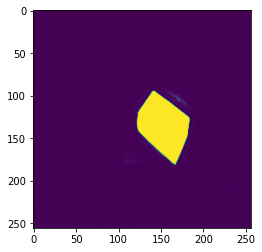

In [32]:
# Это для постороения графика обучения в real-time
writer = SummaryWriter()

# Training loop

for epoch in range(n_epochs):
    print(f'Epoch {epoch}/{n_epochs}')
    model.train()   # set all layers to 'train' mode

    for j, (x, y) in enumerate(train_loader):
        print(f'Iteration {j}/{len(train_loader)}')
        x = x.cuda()
        y = y.cuda()

        y_pred = model(x)    # делаем предсказание

        # plt.imshow(y.cpu().numpy()[2][0])
        plt.imshow(y_pred.detach().cpu().numpy()[2][0])

        loss = criterion(y_pred, y)  # Loss function call
        
        loss.backward()     # Backward propogation
        
        optimizer.step()
        optimizer.zero_grad()
        
        train_acc = AccuracyFunction(y.cpu() >= 0,
                         y_pred.detach().cpu() >= 0.6)

        writer.add_scalar('Loss/train', loss.item(), epoch * len(train_loader) + j)
        writer.add_scalar('Acc/train', train_acc, epoch * len(train_loader) + j)
    
    # Здесь мы просто вызываем тестовую выборку
    with torch.no_grad():
         model.eval()   # set all layers to 'work' mode
         for j, (x, y) in enumerate(val_loader):
            x = x.cuda()
            y = y.cuda()

            y_pred = model(x)
            loss = criterion(y_pred, y)

            test_acc = AccuracyFunction(y.cpu() >= 0,
                            (y_pred.cpu() >= 0.6))
            
            writer.add_scalar('Loss/val', loss, epoch * len(val_loader) + j)
            writer.add_scalar('Acc/val', test_acc, epoch * len(val_loader) + j)


In [33]:
torch.save(model, './gdrive/My Drive/COS/box_find/model4.pt')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type my_model. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


# Testing model

In [34]:
testing_model = torch.load('./gdrive/My Drive/COS/box_find/model4.pt')
testing_model.cuda()

my_model(
  (encoder1): Sequential(
    (block1conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (block1norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (block1relu1): ReLU(inplace=True)
    (block1conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (block1norm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (block1relu2): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder2): Sequential(
    (block2conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (block2norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (block2relu1): ReLU(inplace=True)
    (block2conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (block2norm2): BatchNorm2d(64, eps=1e-05, mome

In [35]:
testing_dataset_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=1)

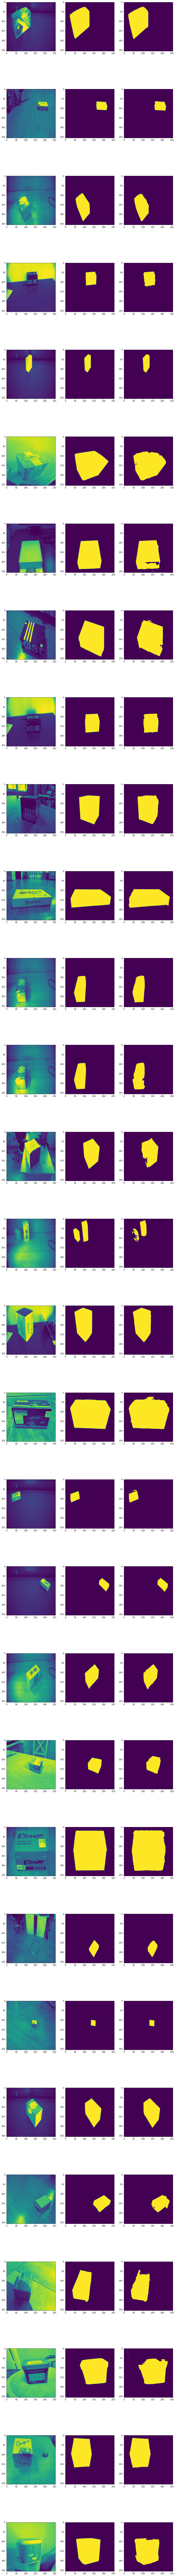

In [40]:
num_of_images = 30

fig = plt.figure(figsize=(15, num_of_images * 8))

with torch.no_grad():
    model.eval()
    
    for i, (x, y) in enumerate(testing_dataset_loader):

        if i >= num_of_images:
            break

        x = x.cuda()
        y = y.cuda()

        y_pred = model(x)    # делаем предсказание

        fig.add_subplot(num_of_images, 3, 3 * i + 1)
        plt.imshow(x.cpu().numpy()[0][0])

        fig.add_subplot(num_of_images, 3, 3 * i + 2)
        # print(y.cpu().numpy()[0][0])
        plt.imshow(y.cpu().numpy()[0][0])

        fig.add_subplot(num_of_images, 3, 3 * i + 3)
        # print(y_pred.detach().cpu().numpy()[0][0])
        plt.imshow((y_pred.detach().cpu().numpy()[0][0] >= 0.05) * 1.)
    
    plt.show()
